# Schrodinger - Neurons x Layers

*2023-11-20*

Based on: <https://github.com/maziarraissi/PINNs/tree/master/main/continuous_time_inference%20(Schrodinger)/>

In [1]:
DATA_SCHR = 'NLS.mat'
! gdown --id 1MnLs5EKYWT6eW4Kg7AG6GmX_Xm4kVbqE

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1MnLs5EKYWT6eW4Kg7AG6GmX_Xm4kVbqE
To: /content/NLS.mat
100% 560k/560k [00:00<00:00, 135MB/s]


- [pyDOE](https://pythonhosted.org/pyDOE/randomized.html#latin-hypercube)
(includes the Latin-Hypercube):

In [2]:
! pip install pyDOE -q

  Preparing metadata (setup.py) ... done


## Parameters

In [3]:
import numpy as np

noise = 0.0

# Doman bounds
lb = np.array([-5.0, 0.0])
ub = np.array([5.0, np.pi/2])

# The training set consists of a total of N0 data points
# on h(0, x) randomly parsed from the full high-resolution data-set
N_0 = 50        #50

# Nb = randomly sampled collocation points for enforcing
# the periodic boundaries
N_b = 50        #50

# Nf = randomly sampled collocation points used to enforce equation
N_f = 20000     #20000

epch = 50000    #50000

layers = [2, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 2]

## Libraries

In [4]:
%env TF_CPP_MIN_LOG_LEVEL=3
import tensorflow as tf
from tensorflow.python.client import device_lib
print(tf.__version__)
print(device_lib.list_local_devices())
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

env: TF_CPP_MIN_LOG_LEVEL=3
2.14.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17105690198180835693
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14410383360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2058242709430947789
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Num GPUs Available:  1


Disable TensorFlow logging output :

In [5]:
import logging, os
logging.disable(logging.WARNING)
logging.getLogger('tensorflow').disabled = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
tf.compat.v1.disable_eager_execution()

In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [9]:
import scipy.io
from scipy.interpolate import griddata

In [10]:
from pyDOE import lhs

In [11]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [12]:
import numpy as np
import time

In [13]:
np.set_printoptions(linewidth=132, precision=6)

Try to make the result reproducible:

In [14]:
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

## Plotting module

In [15]:
def figsize(scale, nplots=1):
    fig_width_pt = 390.0  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch

    # Aesthetic ratio (you could change this)
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0

    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = nplots * fig_width * golden_mean  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size


my_rc_param = {'text.usetex': False}
plt.rcParams.update(my_rc_param)

import matplotlib.pyplot as plt


# I make my own savefig functions
def savefig(filename, crop=True):
    if crop == True:
        # plt.savefig('{}.pgf'.format(filename),
        #             bbox_inches='tight',
        #             pad_inches=0)
        plt.savefig(
            "{}.pdf".format(filename), bbox_inches="tight", pad_inches=0
        )
        plt.savefig(
            "{}.eps".format(filename), bbox_inches="tight", pad_inches=0
        )
    else:
        # plt.savefig('{}.pgf'.format(filename))
        plt.savefig("{}.pdf".format(filename))
        plt.savefig("{}.eps".format(filename))


# I make my own newfig and savefig functions
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

## PINN code

In [16]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, v0, tb, X_f, layers, lb, ub):
        X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
        X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
        X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)

        self.lb = lb
        self.ub = ub

        self.x0 = X0[:, 0:1]
        self.t0 = X0[:, 1:2]

        self.x_lb = X_lb[:, 0:1]
        self.t_lb = X_lb[:, 1:2]

        self.x_ub = X_ub[:, 0:1]
        self.t_ub = X_ub[:, 1:2]

        self.x_f = X_f[:, 0:1]
        self.t_f = X_f[:, 1:2]

        self.u0 = u0
        self.v0 = v0

        # Initialize NNs
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # tf Placeholders
        self.x0_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.x0.shape[1]]
        )
        self.t0_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.t0.shape[1]]
        )

        self.u0_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.u0.shape[1]]
        )
        self.v0_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.v0.shape[1]]
        )

        self.x_lb_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.x_lb.shape[1]]
        )
        self.t_lb_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.t_lb.shape[1]]
        )

        self.x_ub_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.x_ub.shape[1]]
        )
        self.t_ub_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.t_ub.shape[1]]
        )

        self.x_f_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.x_f.shape[1]]
        )
        self.t_f_tf = tf.compat.v1.placeholder(
            tf.float32, shape=[None, self.t_f.shape[1]]
        )

        # tf Graphs
        self.u0_pred, self.v0_pred, _, _ = self.net_uv(
            self.x0_tf, self.t0_tf
        )
        (
            self.u_lb_pred,
            self.v_lb_pred,
            self.u_x_lb_pred,
            self.v_x_lb_pred,
        ) = self.net_uv(self.x_lb_tf, self.t_lb_tf)
        (
            self.u_ub_pred,
            self.v_ub_pred,
            self.u_x_ub_pred,
            self.v_x_ub_pred,
        ) = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred, self.f_v_pred = self.net_f_uv(
            self.x_f_tf, self.t_f_tf
        )

        # Loss
        self.loss = (
            tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred))
            + tf.reduce_mean(tf.square(self.v0_tf - self.v0_pred))
            + tf.reduce_mean(tf.square(self.u_lb_pred - self.u_ub_pred))
            + tf.reduce_mean(tf.square(self.v_lb_pred - self.v_ub_pred))
            + tf.reduce_mean(
                tf.square(self.u_x_lb_pred - self.u_x_ub_pred)
            )
            + tf.reduce_mean(
                tf.square(self.v_x_lb_pred - self.v_x_ub_pred)
            )
            + tf.reduce_mean(tf.square(self.f_u_pred))
            + tf.reduce_mean(tf.square(self.f_v_pred))
        )

        # Optimizers
        # self.optimizer = tf.compat.v1.contrib.opt.ScipyOptimizerInterface(
        #     self.loss,
        #     method="L-BFGS-B",
        #     options={
        #         "maxiter": 50000,
        #         "maxfun": 50000,
        #         "maxcor": 50,
        #         "maxls": 50,
        #         "ftol": 1.0 * np.finfo(float).eps,
        #     },
        # )
        self.optimizer = tf.compat.v1.train.AdamOptimizer()
        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)

        # tf session
        self.sess = tf.compat.v1.Session(
            config=tf.compat.v1.ConfigProto(
                allow_soft_placement=True, log_device_placement=True
            )
        )

        init = tf.compat.v1.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(
                tf.zeros([1, layers[l + 1]], dtype=tf.float32),
                dtype=tf.float32,
            )
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(
            tf.compat.v1.truncated_normal(
                [in_dim, out_dim], stddev=xavier_stddev
            ),
            dtype=tf.float32,
        )

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_uv(self, x, t):
        X = tf.concat([x, t], 1)

        uv = self.neural_net(X, self.weights, self.biases)
        u = uv[:, 0:1]
        v = uv[:, 1:2]

        u_x = tf.gradients(u, x)[0]
        v_x = tf.gradients(v, x)[0]

        return u, v, u_x, v_x

    def net_f_uv(self, x, t):
        u, v, u_x, v_x = self.net_uv(x, t)

        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]

        v_t = tf.gradients(v, t)[0]
        v_xx = tf.gradients(v_x, x)[0]

        f_u = u_t + 0.5 * v_xx + (u**2 + v**2) * v
        f_v = v_t - 0.5 * u_xx - (u**2 + v**2) * u

        return f_u, f_v

    def callback(self, loss):
        print("Loss:", loss)

    def train(self, nIter):
        tf_dict = {
            self.x0_tf: self.x0,
            self.t0_tf: self.t0,
            self.u0_tf: self.u0,
            self.v0_tf: self.v0,
            self.x_lb_tf: self.x_lb,
            self.t_lb_tf: self.t_lb,
            self.x_ub_tf: self.x_ub,
            self.t_ub_tf: self.t_ub,
            self.x_f_tf: self.x_f,
            self.t_f_tf: self.t_f,
        }

        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print(
                    "It: %d, Loss: %.3e, Time: %.2f" % (it, loss_value, elapsed)
                )
                start_time = time.time()


    def predict(self, X_star):
        tf_dict = {
            self.x0_tf: X_star[:, 0:1],
            self.t0_tf: X_star[:, 1:2],
        }

        u_star = self.sess.run(self.u0_pred, tf_dict)
        v_star = self.sess.run(self.v0_pred, tf_dict)

        tf_dict = {
            self.x_f_tf: X_star[:, 0:1],
            self.t_f_tf: X_star[:, 1:2],
        }

        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        f_v_star = self.sess.run(self.f_v_pred, tf_dict)

        return u_star, v_star, f_u_star, f_v_star

## Main

In [17]:
data  = scipy.io.loadmat(DATA_SCHR)

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

idx_x = np.random.choice(x.shape[0], N_0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

X_f = lb + (ub-lb)*lhs(2, N_f)

## Model

Configure the model. Run on GPU:

In [18]:
%%time
model = PhysicsInformedNN(x0, u0, v0, tb, X_f, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5

CPU times: user 5.89 s, sys: 101 ms, total: 5.99 s
Wall time: 7.31 s


## Train - compute intensive part

In [19]:
%%time
model.train(epch)

Streaming output truncated to the last 5000 lines.
It: 20, Loss: 4.574e-01, Time: 1.19
It: 30, Loss: 4.518e-01, Time: 1.38
It: 40, Loss: 4.490e-01, Time: 1.21
It: 50, Loss: 4.471e-01, Time: 1.42
It: 60, Loss: 4.448e-01, Time: 1.53
It: 70, Loss: 4.391e-01, Time: 1.63
It: 80, Loss: 4.434e-01, Time: 1.43
It: 90, Loss: 4.721e-01, Time: 1.38
It: 100, Loss: 4.466e-01, Time: 1.35
It: 110, Loss: 4.354e-01, Time: 1.24
It: 120, Loss: 4.153e-01, Time: 1.25
It: 130, Loss: 2.982e-01, Time: 1.18
It: 140, Loss: 2.972e-01, Time: 1.22
It: 150, Loss: 1.777e-01, Time: 1.04
It: 160, Loss: 1.546e-01, Time: 1.10
It: 170, Loss: 1.413e-01, Time: 1.17
It: 180, Loss: 1.262e-01, Time: 1.18
It: 190, Loss: 1.113e-01, Time: 1.10
It: 200, Loss: 9.960e-02, Time: 1.05
It: 210, Loss: 8.964e-02, Time: 1.04
It: 220, Loss: 8.230e-02, Time: 1.03
It: 230, Loss: 7.720e-02, Time: 1.04
It: 240, Loss: 7.361e-02, Time: 1.03
It: 250, Loss: 7.084e-02, Time: 1.02
It: 260, Loss: 1.033e-01, Time: 1.02
It: 270, Loss: 7.561e-02, Time: 

## Predict

In [20]:
%%time
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
h_pred = np.sqrt(u_pred**2 + v_pred**2)

CPU times: user 664 ms, sys: 5.81 ms, total: 670 ms
Wall time: 686 ms


## Error

In [21]:
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)
print('Error u: %e' % (error_u))
print('Error v: %e' % (error_v))
print('Error h: %e' % (error_h))

Error u: 1.969353e-01
Error v: 3.145990e-01
Error h: 5.415494e-02


com epoch = 50000

Error u: 7.499224e-02

Error v: 1.213059e-01

Error h: 2.025874e-02


In [22]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

## Plotting

<ipython-input-23-33db27e2ea25>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


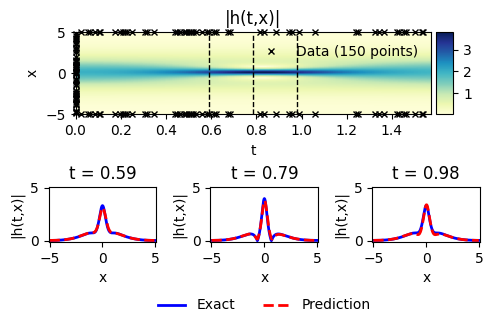

In [23]:
X0 = np.concatenate((x0, 0 * x0), 1)  # (x0, 0)
X_lb = np.concatenate((0 * tb + lb[0], tb), 1)  # (lb[0], tb)
X_ub = np.concatenate((0 * tb + ub[0], tb), 1)  # (ub[0], tb)
X_u_train = np.vstack([X0, X_lb, X_ub])

fig, ax = newfig(1.0, 0.9)
ax.axis("off")

####### Row 0: h(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06, bottom=1 - 1 / 3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])
h = ax.imshow(H_pred.T,
              interpolation="nearest",
              cmap="YlGnBu",
              extent=[lb[1], ub[1], lb[0], ub[0]],
              origin="lower",
              aspect="auto")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        "kx",
        label="Data (%d points)" % (X_u_train.shape[0]),
        markersize=4,
        clip_on=False)
line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[75] * np.ones((2, 1)), line, "k--", linewidth=1)
ax.plot(t[100] * np.ones((2, 1)), line, "k--", linewidth=1)
ax.plot(t[125] * np.ones((2, 1)), line, "k--", linewidth=1)
ax.set_xlabel("t")
ax.set_ylabel("x")
leg = ax.legend(frameon=False, loc="best")
ax.set_title("|h(t,x)|")

####### Row 1: h(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1 - 1 / 3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact_h[:, 75], "b-", linewidth=2, label="Exact")
ax.plot(x, H_pred[75, :], "r--", linewidth=2, label="Prediction")
ax.set_xlabel("x")
ax.set_ylabel("|h(t,x)|")
ax.set_title("t = %.2f" % (t[75]))
ax.axis("square")
ax.set_xlim([-5.1, 5.1])
ax.set_ylim([-0.1, 5.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x, Exact_h[:, 100], "b-", linewidth=2, label="Exact")
ax.plot(x, H_pred[100, :], "r--", linewidth=2, label="Prediction")
ax.set_xlabel("x")
ax.set_ylabel("|h(t,x)|")
ax.axis("square")
ax.set_xlim([-5.1, 5.1])
ax.set_ylim([-0.1, 5.1])
ax.set_title("t = %.2f" % (t[100]))
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.8), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x, Exact_h[:, 125], "b-", linewidth=2, label="Exact")
ax.plot(x, H_pred[125, :], "r--", linewidth=2, label="Prediction")
ax.set_xlabel("x")
ax.set_ylabel("|h(t,x)|")
ax.axis("square")
ax.set_xlim([-5.1, 5.1])
ax.set_ylim([-0.1, 5.1])
ax.set_title("t = %.2f" % (t[125]))

plt.show()

In [24]:
!nvidia-smi

Tue Nov 21 03:05:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |   2549MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------